In [3]:
import numpy as np
from scipy.stats import gamma, cauchy, multivariate_normal, norm

In [22]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
def accept_reject(accept_prob):
    u = np.random.uniform(low=0.0, high=1.0, size=1)
    return u < accept_prob

In [12]:
def l_gamma_prior(l, a, b):
    return gamma.pdf(l, a=a, scale=1/b)

In [13]:
def s_half_cauchy_prior(s, scale):
    return 2 * cauchy.pdf(s, loc=0, scale=scale)

In [14]:
def kernel_covariance(x, l, s, noise=1e-3):
    t = x.shape[0]
    cov_sample = np.zeros((t, t))
    for i in range(t):
        for j in range(t):
            cov_sample[i, j] = s ** 2 * np.exp(-(x[i] - x[j]) ** 2 / (2 * l ** 2))
    cov_sample += np.eye(t) * noise
    return cov_sample

In [15]:
def gp_marginal_likelihood(y, x, l, s):
    t = y.shape[0]
    mu = np.repeat(0, t)
    cov = kernel_covariance(x, l, s)
    return multivariate_normal.pdf(y, mu, cov)

In [31]:
def propose_new(current, std):
    value = -1
    while value < 0:
        value = np.random.normal(loc=current, scale=std, size=1)
    return value

In [32]:
def calculate_p(l, s, y, x, prior_params):
    a, b, scale = prior_params
    return l_gamma_prior(l, a, b) * s_half_cauchy_prior(s, scale) * gp_marginal_likelihood(y, x, l, s)

In [33]:
def metropolis_update(l, s, y, x, prior_params, proposal_params):
    p_current = calculate_p(l, s, y, x, prior_params)

    l_new = propose_new(l, proposal_params[0])
    s_new = propose_new(s, proposal_params[1])

    p_new = calculate_p(l_new, s_new, y, x, prior_params)
    
    if accept_reject(p_new / p_current):
        return l_new, s_new
    else:
        return l, s

In [64]:
from tqdm import tqdm as tqdm

In [65]:
def metropolis_sample(n_iter, y, x, prior_params=[10, 0.1, 0.5], proposal_params=[0.5, 0.5]):
    l = propose_new(1, proposal_params[0])
    s = propose_new(1, proposal_params[1])
    
    l_trace = []
    s_trace = []
    for i in tqdm(range(n_iter)):
        l, s = metropolis_update(l, s, y, x, prior_params, proposal_params)
        l_trace.append(l)
        s_trace.append(s)
        #for j in range(10):
        #    extra = gp_marginal_likelihood(y, x, l, s)
    
    return l_trace, s_trace

In [66]:
x = np.linspace(0.1, 10, 100)
y = np.sin(x) + np.random.normal(0, 0.01, 100)

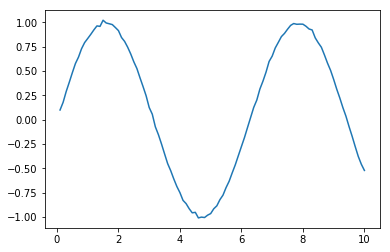

In [67]:
plt.plot(x, y)
plt.show()

In [68]:
import time

In [69]:
t0 = time.time()

for i in range(50):
    l = 1 + i * 0.01
    s = 1 + i * 0.01
    gp_marginal_likelihood(y, x, l, s)
    
t1 = time.time()
print(t1 - t0)

2.05952000618


In [70]:
t0 = time.time()

test = metropolis_sample(50, y, x)

t1 = time.time()
print(t1 - t0)

100%|██████████| 50/50 [01:02<00:00,  1.25s/it]

62.2289600372


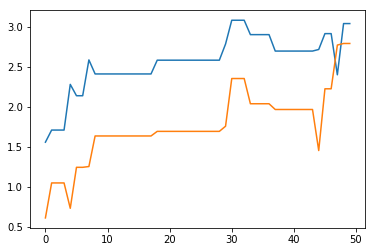

In [71]:
plt.plot(test[0])
plt.plot(test[1])
plt.show()

In [73]:
from gibbs import *

In [85]:
mu_0 = np.repeat(0, 10)  # prior mean 0 for regression coefficients
Sigma_0 = np.diag(np.repeat(1, 10))  # prior variance 1
a_0 = 1  # Inverse-Gamma(1, 1) is fairly diffused
b_0 = 1

In [86]:
F = np.random.normal(0, 1, [10000, 10])
loading = np.random.normal(0, 1, [10, 100])
Y = np.matmul(F, loading) + np.random.normal(0, 0.1, [10000, 100])

In [87]:
t0 = time.time()

loading_matrix, Y_variance = blr_mv(Y, F, mu_0, Sigma_0, a_0, b_0)

t1 = time.time()
print(t1 - t0)

0.16050195694


In [95]:
cov1 = kernel_covariance(x, 1.0, 1.0)
cov2 = kernel_covariance(x, 1.0, 1.0)
loading_matrix = np.random.normal(0, 1, [2, 20])
Y_variance = np.random.normal(0, 1, 20) ** 2
Y = np.random.normal(0, 1, [100, 20])

In [96]:
t0 = time.time()

for i in range(50):
    S1, S2, S3, S4 = build_covariance_blocks([cov1, cov2], loading_matrix, Y_variance)
    F_new, cov_new = sample_conditional_F(Y, S1, S2, S3, S4, debug=True)
    
t1 = time.time()
print(t1 - t0)

34.1250851154
